In [22]:
import pandas as pd
import openai
import json
import os
import unidecode
from sklearn.metrics import confusion_matrix
from heatmap import make_confusion_matrix

In [7]:
token_path = 'tokens.json'
if not os.path.isfile(token_path):
    raise Exception(f"{token_path} not found!")
with open(token_path) as f:
    tokens = json.load(f)
    openai.organization = tokens['openai.organization']
    openai.api_key = tokens['openai.api_key']

In [24]:
def replace_unicode_from_text(text):
    try:
        return unidecode(text)
    except:
        return text

reporting_categories = [
    'user is a bot',
    'user is pretending to be someone else',
    'user is a minor',
    'user is trying to get money (eg. asking for Venmo, CashApp)',
]

def message_autoflag(message, openai_model='gpt-3.5-turbo'):
    prompt = \
'''Pick a number 1-5 for the following categories. Do not respond with anything else.
1. %s
2. %s
3. %s
4. %s
5. none

Message: %s
Number: ''' % (reporting_categories[0], reporting_categories[1], reporting_categories[2], reporting_categories[3], replace_unicode_from_text(message))
    response = openai.ChatCompletion.create(
        model=openai_model,
        messages=[
                {"role": "system", "content": "You are a helpful assistant for trust and safety engineering on a dating app"},
                {"role": "user", "content": prompt},
            ]
    )
    category_response = response['choices'][0]['message']['content']
    for i in range(1, 6):
        if f'{i}' in category_response:
            return i
    return 5


In [3]:
df = pd.read_csv('dataset.csv')

In [19]:
actual_vals, pred_vals = [], []
for idx, rows in df.iterrows():
    actual_vals.append(rows['Category'])
    pred_vals.append(message_autoflag(rows['Message']))
conf_matrix = confusion_matrix(actual_vals, pred_vals)

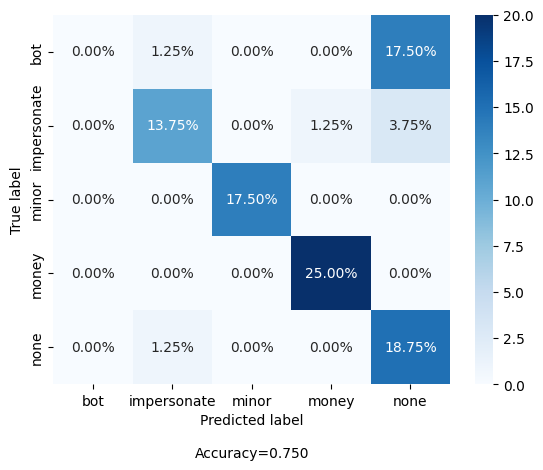

In [23]:
make_confusion_matrix(conf_matrix, categories=['bot', 'impersonate', 'minor', 'money', 'none'], count=False)

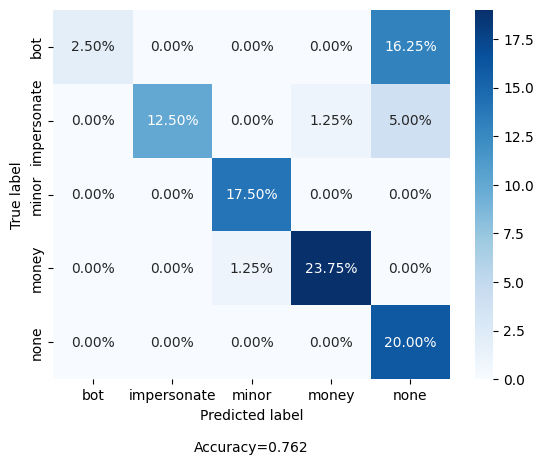

In [25]:
## with GPT-4
actual_vals, pred_vals = [], []
for idx, rows in df.iterrows():
    actual_vals.append(rows['Category'])
    pred_vals.append(message_autoflag(rows['Message'], 'gpt-4'))
conf_matrix = confusion_matrix(actual_vals, pred_vals)
make_confusion_matrix(conf_matrix, categories=['bot', 'impersonate', 'minor', 'money', 'none'], count=False)